In [3]:
import pandas as pd
import glob
import os

# --- AYARLAR ---
dosya_yolu = "data/"
# Ondalık ayracı ',' ve sütun ayracı ';' olduğu için parametreleri ekliyoruz
params = {'sep': ';', 'decimal': ',', 'encoding': 'utf-8'}

# --- 1. DOSYALARI BULMA ---
# Üretim dosyalarını bul
dosyalar_uretim = glob.glob(os.path.join(dosya_yolu, "Gercek_Zamanli_Uretim*.csv"))
print(f"Bulunan Üretim dosyası sayısı: {len(dosyalar_uretim)}")

# --- 2. OKUMA VE BİRLEŞTİRME ---
dfs = []
for f in dosyalar_uretim:
    df = pd.read_csv(f, **params)
    dfs.append(df)

df_uretim = pd.concat(dfs, ignore_index=True)

# --- 3. TARİH VE SAAT DÜZENLEMESİ (KRİTİK ADIM) ---
# 'Tarih' ve 'Saat' sütunlarını birleştirip Python'ın anlayacağı tek bir tarih formatına çeviriyoruz.
# Örn: "01.01.2024" ve "00:00" -> 2024-01-01 00:00:00

# Tarih formatını datetime objesine çevir
df_uretim['TarihSaat'] = pd.to_datetime(df_uretim['Tarih'] + ' ' + df_uretim['Saat'], format='%d.%m.%Y %H:%M')

# Gereksiz eski sütunları atabiliriz (İsteğe bağlı)
# df_uretim = df_uretim.drop(columns=['Tarih', 'Saat'])

# --- 4. SONUÇLARI KONTROL ET ---
print("\n--- İŞLEM BAŞARILI ---")
print(df_uretim.info())
print("\n--- İLK 5 SATIR ---")
print(df_uretim[['TarihSaat', 'Toplam', 'Doğal Gaz', 'Güneş', 'Rüzgar']].head())

Bulunan Üretim dosyası sayısı: 8

--- İŞLEM BAŞARILI ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17613 entries, 0 to 17612
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Tarih           17613 non-null  object        
 1   Saat            17613 non-null  object        
 2   Toplam          17613 non-null  float64       
 3   Doğal Gaz       17613 non-null  float64       
 4   Barajlı         17613 non-null  float64       
 5   Linyit          17613 non-null  float64       
 6   Akarsu          17613 non-null  float64       
 7   İthal Kömür     17613 non-null  float64       
 8   Rüzgar          17613 non-null  float64       
 9   Güneş           17613 non-null  float64       
 10  Fuel Oil        17613 non-null  float64       
 11  Jeotermal       17613 non-null  float64       
 12  Asfaltit Kömür  17613 non-null  float64       
 13  Taş Kömür       17613 non-null  float64       
 1

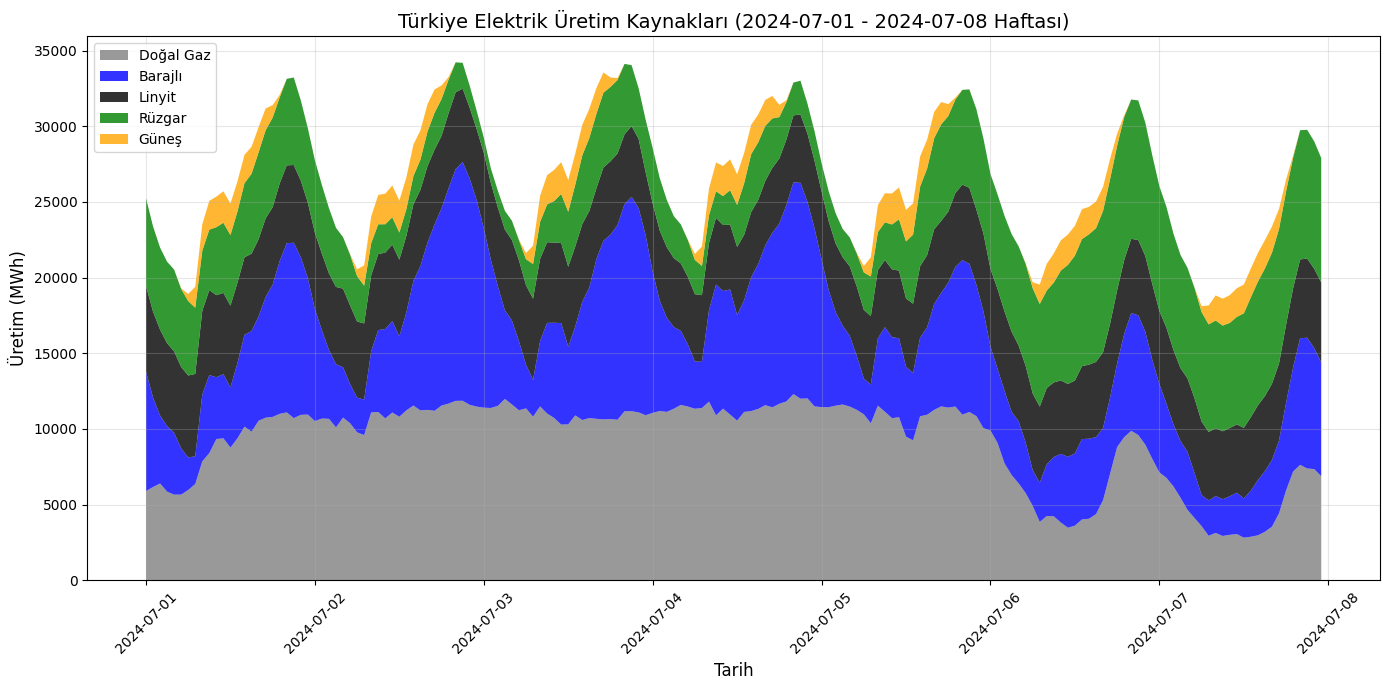

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TEMİZLİK: Dosyalar birleşirken üst üste binen tarihler olmuş olabilir, temizleyelim.
df_uretim = df_uretim.drop_duplicates(subset=['TarihSaat']).sort_values('TarihSaat')

# 2. SEÇİM: Tüm 2 yılı çizdirirsek karışır. Örnek olarak 2024 Temmuz ayından 1 haftaya bakalım (Güneşin bol olduğu zaman).
baslangic = '2024-07-01'
bitis = '2024-07-08'
maske = (df_uretim['TarihSaat'] >= baslangic) & (df_uretim['TarihSaat'] < bitis)
df_haftalik = df_uretim.loc[maske]

# 3. GRAFİK ÇİZİMİ (Yığılmış Alan Grafiği)
plt.figure(figsize=(14, 7))

# Görmek istediğimiz ana kaynaklar
kaynaklar = ['Doğal Gaz', 'Barajlı', 'Linyit', 'Rüzgar', 'Güneş']
renkler = ['gray', 'blue', 'black', 'green', 'orange']

# Stackplot (Üst üste yığılmış grafik)
plt.stackplot(df_haftalik['TarihSaat'], 
              [df_haftalik[k] for k in kaynaklar],
              labels=kaynaklar,
              colors=renkler,
              alpha=0.8)

plt.title(f'Türkiye Elektrik Üretim Kaynakları ({baslangic} - {bitis} Haftası)', fontsize=14)
plt.ylabel('Üretim (MWh)', fontsize=12)
plt.xlabel('Tarih', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [5]:
# --- TÜKETİM VERİLERİNİ EKLEME VE BİRLEŞTİRME ---

# 1. Tüketim Dosyalarını Bul (İsminde 'Gercek_Zamanli_Tuketim' geçen csv'leri arar)
# Not: Dosya isminiz farklıysa buradaki "Tuketim" kelimesini dosya ismine göre değiştirin.
dosyalar_tuketim = glob.glob(os.path.join(dosya_yolu, "*Gercek_Zamanli_Tuketim*.csv")) 

print(f"Bulunan Tüketim dosyası sayısı: {len(dosyalar_tuketim)}")

dfs_tuketim = []
for f in dosyalar_tuketim:
    # Tüketim verileri de genelde noktalı virgül ile ayrılır
    df = pd.read_csv(f, **params)
    dfs_tuketim.append(df)

if len(dfs_tuketim) > 0:
    df_tuketim_ham = pd.concat(dfs_tuketim, ignore_index=True)
    
    # Tarih ve Saat'i datetime'a çevir (Üretim verisiyle aynı formatta)
    df_tuketim_ham['TarihSaat'] = pd.to_datetime(df_tuketim_ham['Tarih'] + ' ' + df_tuketim_ham['Saat'], format='%d.%m.%Y %H:%M')
    
    # Sadece TarihSaat ve Tüketim miktarını alalım (Sütun adı genelde 'Tüketim' veya 'Tüketim Miktarı (MWh)' olur)
    # Sütun adını kontrol edip doğrusunu seçiyoruz:
    col_tuketim = 'Tüketim' if 'Tüketim' in df_tuketim_ham.columns else df_tuketim_ham.columns[2] # 3. sütun genelde veridir
    
    df_tuketim_clean = df_tuketim_ham[['TarihSaat', col_tuketim]].rename(columns={col_tuketim: 'Tuketim'})
    
    # 2. Üretim ve Tüketimi TarihSaat üzerinden BİRLEŞTİR (Merge)
    df_final = pd.merge(df_uretim, df_tuketim_clean, on='TarihSaat', how='inner')
    
    print("--- BİRLEŞTİRME BAŞARILI ---")
    print(df_final[['TarihSaat', 'Toplam', 'Güneş', 'Tuketim']].head())
else:
    print("HATA: Tüketim dosyası bulunamadı! Lütfen dosya ismini kontrol edin.")

Bulunan Tüketim dosyası sayısı: 2
--- BİRLEŞTİRME BAŞARILI ---
            TarihSaat    Toplam  Güneş    Tuketim
0 2024-01-01 00:00:00  28876.95   0.01  28.929,45
1 2024-01-01 01:00:00  27658.01   0.01  27.713,39
2 2024-01-01 02:00:00  26286.14   0.01  26.342,91
3 2024-01-01 03:00:00  25301.83   0.01  25.356,82
4 2024-01-01 04:00:00  24692.58   0.01  24.748,98


In [7]:
# --- HATA DÜZELTME: Tüketim Verisini Sayıya Çevirme ---

# 1. Önce veriyi string (yazı) formatına garanti alalım
df_final['Tuketim'] = df_final['Tuketim'].astype(str)

# 2. Binlik ayracı olan noktaları (.) silelim. (Örn: 28.929 -> 28929)
df_final['Tuketim'] = df_final['Tuketim'].str.replace('.', '', regex=False)

# 3. Ondalık ayracı olan virgülü (,) noktaya (.) çevirelim. (Örn: 28929,45 -> 28929.45)
df_final['Tuketim'] = df_final['Tuketim'].str.replace(',', '.')

# 4. Artık format düzgün olduğuna göre Python'a "bu bir sayıdır" diyelim
df_final['Tuketim'] = pd.to_numeric(df_final['Tuketim'])

print("--- DÜZELTME TAMAMLANDI ---")
print(df_final[['TarihSaat', 'Tuketim']].head())
print(df_final['Tuketim'].dtypes) # Burası artık 'float64' yazmalı

--- DÜZELTME TAMAMLANDI ---
            TarihSaat   Tuketim
0 2024-01-01 00:00:00  28929.45
1 2024-01-01 01:00:00  27713.39
2 2024-01-01 02:00:00  26342.91
3 2024-01-01 03:00:00  25356.82
4 2024-01-01 04:00:00  24748.98
float64


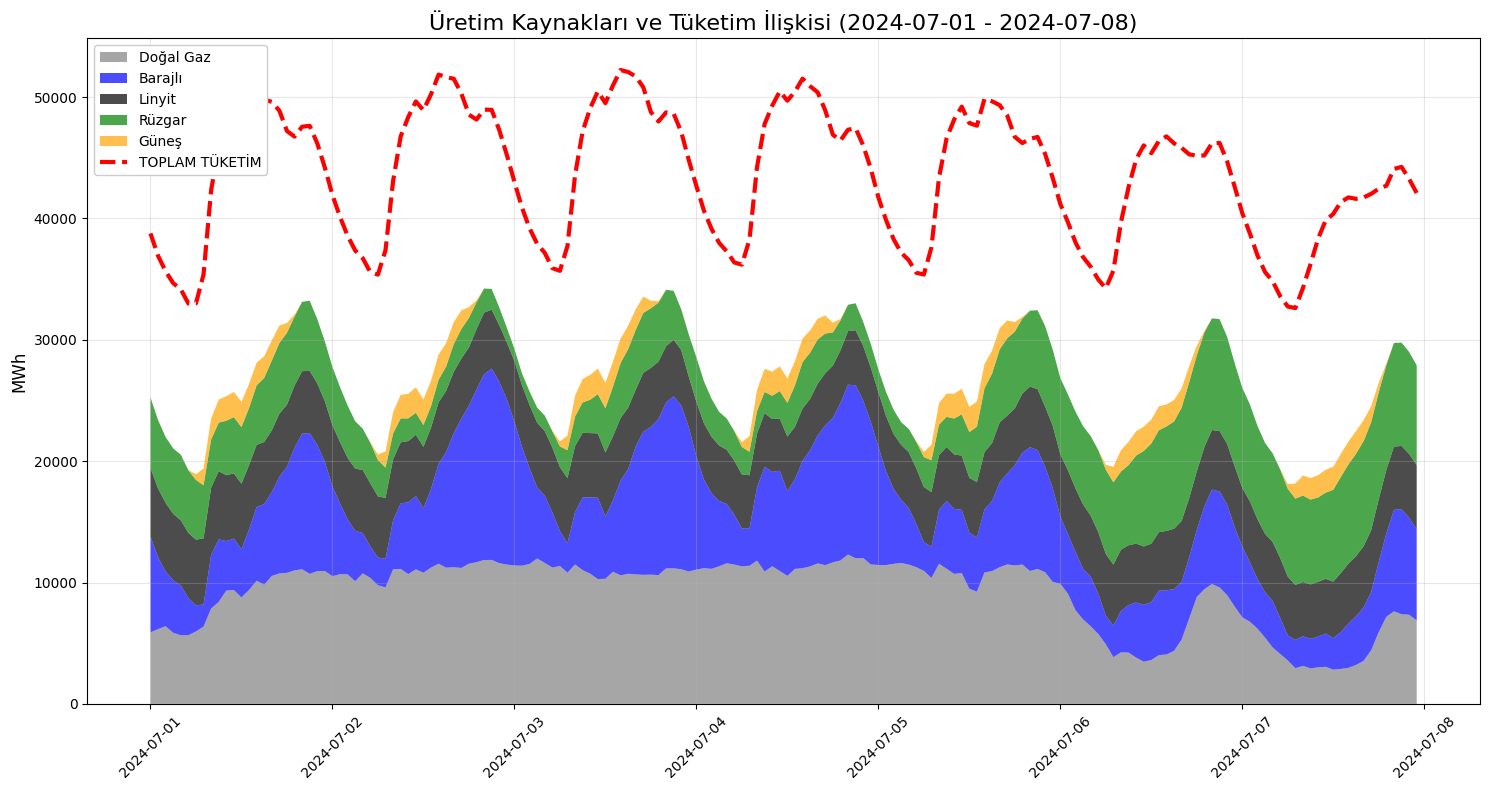

In [8]:
# --- FİNAL GRAFİK: ÜRETİM KAYNAKLARI vs TÜKETİM ---

# Yine aynı hafta örneği üzerinden gidelim
maske = (df_final['TarihSaat'] >= baslangic) & (df_final['TarihSaat'] < bitis)
df_analiz = df_final.loc[maske]

plt.figure(figsize=(15, 8))

# 1. Arka Plan: Üretim Kaynakları (Stackplot)
plt.stackplot(df_analiz['TarihSaat'], 
              [df_analiz[k] for k in kaynaklar],
              labels=kaynaklar,
              colors=renkler,
              alpha=0.7)

# 2. Ön Plan: Tüketim Çizgisi (Kırmızı Çizgi)
# Bu çizgi, elektriğin ne kadar harcandığını gösterir.
plt.plot(df_analiz['TarihSaat'], df_analiz['Tuketim'], 
         color='red', linewidth=3, label='TOPLAM TÜKETİM', linestyle='--')

plt.title(f'Üretim Kaynakları ve Tüketim İlişkisi ({baslangic} - {bitis})', fontsize=16)
plt.ylabel('MWh', fontsize=12)
plt.legend(loc='upper left', frameon=True, facecolor='white', framealpha=1)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()